In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
mtalbert = pd.read_csv('../Data/soil data/AcrossAucklandRainfallStation/MtAlbert_Data_15mins.csv', parse_dates=['Timestamp (UTC+12:00)'])
mtalbert.head()

,Timestamp (UTC+12:00),Rain(mm),SoilTemp(c),SoilMoisture(%)
0,2018-07-07 11:15:00,0.0,10.4,37.364
1,2018-07-07 11:30:00,0.0,10.4,37.594
2,2018-07-07 11:45:00,0.0,10.4,37.590
3,2018-07-07 12:00:00,0.0,10.5,37.587
4,2018-07-07 12:15:00,0.0,10.5,37.584


Resample Data to 15 minutes interval

In [22]:
mtalbert.set_index('Timestamp (UTC+12:00)', inplace=True)

resampled_df = mtalbert.resample('H').agg({
    'Rain(mm)': 'sum',
    'SoilTemp(c)': 'mean',
    'SoilMoisture(%)': 'mean'
})

C:\Users\Ying\AppData\Local\Temp\ipykernel_17512\2774863814.py:3: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  resampled_df = mtalbert.resample('H').agg({


Cross-correlation

In [23]:
import numpy as np
from scipy.signal import correlate
import matplotlib.pyplot as plt

max_lag = 30
def cross_correlation(x, y, max_lag):
    """Calculate cross-correlation between two signals."""
    correlation = correlate(x, y, mode='full')
    lags = np.arange(-len(x) + 1, len(y))
    return lags, correlation

In [24]:
mtalbert_daily = mtalbert.resample('D').agg({'Rain(mm)': 'sum','SoilTemp(c)': 'mean','SoilMoisture(%)': 'mean'})

In [25]:
soil_moisture = mtalbert_daily['SoilMoisture(%)'].values
rainfall = mtalbert_daily['Rain(mm)'].values
soil_temp = mtalbert_daily['SoilTemp(c)'].values

In [26]:
mtalbert_daily.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2299 entries, 2018-07-07 to 2024-10-21
Freq: D
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Rain(mm)         2299 non-null   float64
 1   SoilTemp(c)      1961 non-null   float64
 2   SoilMoisture(%)  1961 non-null   float64
dtypes: float64(3)
memory usage: 71.8 KB


In [27]:
# oneday_lag = 4 * 96 # 1 day, with 4 data points per day (15-minute intervals)


In [1]:
rainfall_lags = [1, 3, 5, 7, 30, 45, 60]  
soil_moisture_lags = [30, 60] 
soil_temp_lags = [1, 3, 7, 14, 28] 

for i in rainfall_lags:
    mtalbert_daily[f'Rainfall_lag_{i}'] = mtalbert_daily['Rain(mm)'].shift(i)

for i in soil_moisture_lags:
    mtalbert_daily[f'SoilMoisture_lag_{i}'] = mtalbert_daily['SoilMoisture(%)'].shift(i)

for i in soil_temp_lags:
    mtalbert_daily[f'SoilTemp_lag_{i}'] = mtalbert_daily['SoilTemp(c)'].shift(i)

# Drop rows with NaN values in the lag features
mtalbert_daily.dropna(inplace=True)

NameError: name 'mtalbert_daily' is not defined

In [ ]:
lag_size = 30
# Calculate cross-correlation for rainfall and soil temperature
lags_rain_temp, correlation_rain_temp = cross_correlation(rainfall, soil_temp, lag_size)
print("Cross-Correlation between Rainfall and Soil Temperature:")
print("Lags:", lags_rain_temp)
print("Correlation:", correlation_rain_temp)

Cross-Correlation between Rainfall and Soil Temperature:
Lags: [-2298 -2297 -2296 ...  2296  2297  2298]
Correlation: [  0.         121.25145679 448.24410383 ...   0.           0.
   0.        ]


In [ ]:

# Calculate cross-correlation for rainfall and soil moisture
lags_rain_moist, correlation_rain_moist = cross_correlation(rainfall, soil_moisture, lag_size)
print("\nCross-Correlation between Rainfall and Soil Moisture:")
print("Lags:", lags_rain_moist)
print("Correlation:", correlation_rain_moist)


Cross-Correlation between Rainfall and Soil Moisture:
Lags: [-2298 -2297 -2296 ...  2296  2297  2298]
Correlation: [   0.          345.97788049 1286.71979198 ...    0.            0.
    0.        ]


In [ ]:
# Calculate cross-correlation for soil moisture and soil temperature
lags_moist_temp, correlation_moist_temp = cross_correlation(soil_moisture, soil_temp, lag_size)
print("\nCross-Correlation between Soil Moisture and Soil Temperature:")
print("Lags:", lags_moist_temp)
print("Correlation:", correlation_moist_temp)


Cross-Correlation between Soil Moisture and Soil Temperature:
Lags: [-2298 -2297 -2296 ...  2296  2297  2298]
Correlation: [ 615.11081104 1211.37476841 1867.08256711 ... 1630.36824825 1055.49788244
  520.1281915 ]


<Axes: >

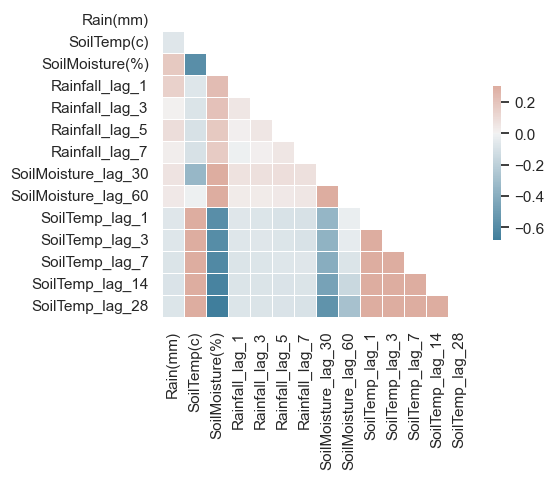

In [ ]:
from string import ascii_letters
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme(style="white")


# Compute the correlation matrix
corr = mtalbert_daily.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(6, 4))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

Predictive Model

In [ ]:
mtalbert_daily.columns

Index(['Rain(mm)', 'SoilTemp(c)', 'SoilMoisture(%)', 'Rainfall_lag_1',
       'Rainfall_lag_3', 'Rainfall_lag_5', 'Rainfall_lag_7',
       'SoilMoisture_lag_30', 'SoilMoisture_lag_60', 'SoilTemp_lag_1',
       'SoilTemp_lag_3', 'SoilTemp_lag_7', 'SoilTemp_lag_14',
       'SoilTemp_lag_28'],
      dtype='object')

In [ ]:
X = mtalbert_daily.drop(columns=['SoilMoisture(%)', 'SoilMoisture_lag_30', 'SoilMoisture_lag_60',])


y = mtalbert_daily[['SoilMoisture(%)']]

X.dropna(inplace=True)

print("X shape:", X.shape)
print("y shape:", y.shape)

X shape: (1829, 11)
y shape: (1829, 1)


In [ ]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# Random Forest model
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from math import sqrt

rf_model = RandomForestRegressor()
rf_model.fit(X_train, y_train)
rf_predictions = rf_model.predict(X_test)

c:\Users\Ying\.conda\envs\level8\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from math import sqrt

def evaluate_model(predictions, y_test):
    mae = mean_absolute_error(y_test, predictions)
    mse = mean_squared_error(y_test, predictions)
    rmse = sqrt(mse)
    r2 = r2_score(y_test, predictions)

    return mae, mse, rmse, r2

rf_mae, rf_mse, rf_rmse, rf_r2 = evaluate_model(rf_predictions, y_test)

print("\nRandom Forest Testing Set Metrics:")
print(f"MAE: {rf_mae}")
print(f"MSE: {rf_mse}")
print(f"RMSE: {rf_rmse}")
print(f"R2 Score: {rf_r2}")


Random Forest Testing Set Metrics:
MAE: 2.4762654457344295
MSE: 10.490415313840746
RMSE: 3.2388910623608114
R2 Score: 0.6283086555285083


First model - hourly without lag day
Random Forest Testing Set Metrics:
MAE: 2.4803292680606406
MSE: 10.352127414009562
RMSE: 3.2174722087392706
R2 Score: 0.6332084058124248

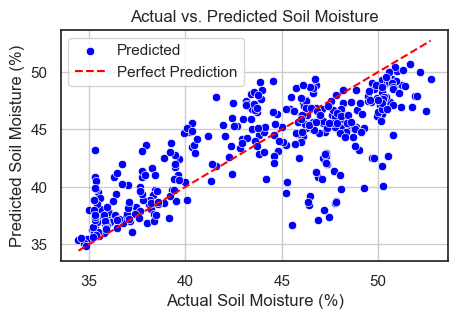

In [ ]:
y_test_df = y_test.reset_index(drop=True)
predictions_df = pd.DataFrame(rf_predictions, columns=['Predicted'])

results_df = pd.concat([y_test_df, predictions_df], axis=1)

plt.figure(figsize=(5, 3))
sns.scatterplot(x=results_df['SoilMoisture(%)'], y=results_df['Predicted'], color='blue', label='Predicted')
plt.plot([results_df['SoilMoisture(%)'].min(), results_df['SoilMoisture(%)'].max()], 
         [results_df['SoilMoisture(%)'].min(), results_df['SoilMoisture(%)'].max()], 
         color='red', linestyle='--', label='Perfect Prediction')
plt.title('Actual vs. Predicted Soil Moisture')
plt.xlabel('Actual Soil Moisture (%)')
plt.ylabel('Predicted Soil Moisture (%)')
plt.legend()
plt.grid()
plt.show()

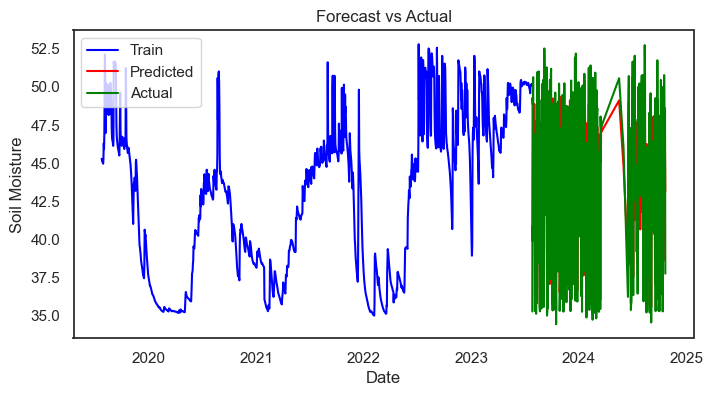

In [ ]:
y_test_df = y_test.reset_index(drop=True)
predictions_df = pd.DataFrame(rf_predictions, columns=['Predicted'])

results_df = pd.concat([y_test_df, predictions_df], axis=1)
results_df.index = mtalbert_daily.index[-len(y_test):] 

plt.figure(figsize=(8, 4))
plt.plot(mtalbert_daily['SoilMoisture(%)'][:len(X_train)], label='Train', color='blue')
plt.plot(results_df.index, results_df['Predicted'], color='red', label='Predicted')
plt.plot(results_df.index, results_df['SoilMoisture(%)'], color='green', label='Actual')
plt.title('Forecast vs Actual')
plt.xlabel('Date')
plt.ylabel('Soil Moisture')
plt.legend()
plt.show()

In [ ]:


# # allstation = ['MtAlbert', 'Ararimu', 'Awhitu', 'Kaipara', 'Mangemangeroa', 'Tomarata', 'waitangi', 'whangamarie']

# metrics_data = {
#     'Station': ['Mt Albert', 'Ararimu', 'Awhitu'],
#     'MAE': [0.01098, 1.2, 1.5], 
#     'MSE': [0.00038, 1.8, 2.1],
#     'RMSE': [0.01953, 1.3, 1.8],
#     'R2 Score': [0.99999, 0.75, 0.70],
# }

# metrics_df = pd.DataFrame(metrics_data)

# metrics_df.set_index('Station').plot(kind='bar', figsize=(5, 4))
# plt.title('Model Evaluation Metrics Comparison')
# plt.ylabel('Metric Value')
# plt.xticks(rotation=0)
# plt.grid(axis='y')
# plt.legend(title='Metrics')
# plt.show()